# Модуль 4. Разработка математического аппарата

In [1]:
# "стандартный" импорт
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import seaborn as sns

## 0. Предисловие
Загрузка и предобработка датасетов для дальнейшей работы над ними. Функции загрузки и подготовки датасетов из модуля 3.

Решение модуля 4 начинается с п.1

In [4]:
# Функция загрузки необходимых датасетов
def load_datasets():
    # грузим оригинальный train.csv
    try:
        train_orig = pd.read_csv('train.csv', nrows=10_000_000)
    except FileNotFoundError:
        print('Файл train.csv отсутствует')
    except Exception as e:
        print(f'Возникла ошибка {e.args[1]}')
        
    # грузим оригинальный objects.csv (который building_meta в задании)
    try:
        building_meta_orig = pd.read_csv('objects.csv')
    except FileNotFoundError:
        print('Файл objects.csv отсутствует')
    except Exception as e:
        print(f'Возникла ошибка {e.args[1]}')
        
    # грузим оригинальный weather_train/test.csv
    try:
        weather_train_orig = pd.read_csv('wtrain.csv')
    except FileNotFoundError:
        print('Файл wtrain.csv отсутствует')
    except Exception as e:
        print(f'Возникла ошибка {e.args[1]}')
    try:
        weather_test_orig = pd.read_csv('wtest.csv')
    except FileNotFoundError:
        print('Файл wtest.csv отсутствует')
    except Exception as e:
        print(f'Возникла ошибка {e.args[1]}')
        
    # грузим test.csv
    try:
        test_orig = pd.read_csv('test.csv', nrows=10000)
    except FileNotFoundError:
        print('Файл test.csv отсутствует')
    except Exception as e:
        print(f'Возникла ошибка {e.args[1]}')
        
    return train_orig, building_meta_orig, weather_train_orig, weather_test_orig, test_orig

Функция подготовки train/test

In [5]:
def prepare_train_test(dataset):
    # исправляем тип datetime
    dataset.datetime = pd.to_datetime(dataset.datetime)
    # удалим столбец **Unnamed: 0**
    if 'Unnamed: 0' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0', axis=1)
    # удалим столбец **Unnamed: 0.1**, если он есть
    if 'Unnamed: 0.1' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0.1', axis=1)
    # Сжимаем obj_id и counter
    dataset.obj_id = dataset.obj_id.astype(np.ushort)
    dataset.counter = dataset.counter.astype(np.uint8)
    # жертвуем точностью во имя памяти
    if 'value' in dataset.columns:
        dataset.value = dataset.value.astype(np.float32)
    
    return dataset

Функция подготовки building_meta

In [6]:
def prepare_building_meta(dataset):
    # сжимаем city
    dataset.city = dataset.city.astype(np.uint8)
    # сжимаем obj_id
    dataset.obj_id = dataset.obj_id.astype(np.ushort)
    # удаляем служебную информацию, т.к. дублирует индекс
    dataset = dataset.drop('Unnamed: 0', axis=1)
    # заполняем пропуски
    dataset.year = dataset.year.fillna(0)
    # сжимаем year
    dataset.year = dataset.year.astype(np.ushort)
    # удаляем floor
    dataset = dataset.drop('floor', axis=1)
    
    # словарь кодирования функции здания
    function_values_dict = {
        'Education': 0,
        'Lodging/residential': 1,
        'Office': 2,
        'Entertainment/public assembly': 3,
        'Other': 4,
        'Retail': 5,
        'Parking': 6,
        'Public services': 7,
        'Warehouse/storage': 8,
        'Food sales and service': 9,
        'Religious worship': 10,
        'Healthcare': 11,
        'Utility': 12,
        'Technology/science': 13,
        'Manufacturing/industrial': 14,
        'Services': 15
    }
    # кодируем
    dataset.function = dataset.function.replace(function_values_dict)
    # сжимаем 
    dataset.function = dataset.function.astype(np.uint8)
    # сжимаем площадь
    dataset.square = dataset.square.astype(np.float32)
    
    return dataset

Функция подготовки погодного датасета

In [7]:
def prepare_weather(dataset):    
    # удаляем дубликаты индекса
    if 'Unnamed: 0' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0', axis=1)
    if 'Unnamed: 0.1' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0.1', axis=1)
        
    # задаём верный тип для дата/времени
    dataset.datetime = pd.to_datetime(dataset.datetime)
    
    # словарь подмен пропусков в датасете
    fillna_weather_dict = {'temp': 15.0,
        'dew': 8.3,
        'pressure': 1016.4,
        'wdirection': 190.0,
        'wspeed': 3.1,
        'precipitation': 0,
        'city': 0,
        'clouds': 0.0
    }
    # заполняем Nan
    for col in fillna_weather_dict.keys():
        dataset[col].fillna(fillna_weather_dict[col], inplace=True)
    
    # сжимаем city
    dataset.city = dataset.city.astype(np.uint8)
    # сжимаем clouds
    dataset.clouds = dataset.clouds.astype(np.uint8)
    # для экономии памяти сожмём float64 до float32?
    for col in ['temp', 'dew', 'pressure', 'wdirection', 'wspeed', 'precipitation']:
        dataset[col] = dataset[col].astype(np.float32)
    
    return dataset

Функция объединения датасетов в один

In [8]:
# на входе train/test, building_meta, wtrain, wtest
def join_datasets(dataset, building_meta, wdataset):
    # сцепляем dataset и building_meta, добавив доп.инфо по объектам
    df = pd.merge(dataset, building_meta, how='left', on='obj_id')
    # результативный датасет по dataset+weather
    return pd.merge(df, wdataset, how='left', on=['city', 'datetime'])

Функция удаления выбросов в датасете (применяется для train)

In [9]:
def remove_noise(dataset):
    # количественные столбцы
    num_vars = ['square', 'temp', 'dew', 'precipitation', 'pressure', 'wspeed', 'value']

    for col in num_vars:
        q1 = dataset[col].quantile(0.25)
        q3 = dataset[col].quantile(0.75)

        iqr = q3 - q1

        dataset = dataset[(dataset[col] >= q1 - 1.5 * iqr) & (dataset[col] <= q3 + 1.5 * iqr)]

    return dataset

Функция добавления новых фич

In [10]:
def feature_engineering(dataset):
    # Декатегоризация (только тех, что останутся)
    dataset = pd.get_dummies(dataset, columns=['counter', 'function'])

    # новые признаки
    # день месяца (число)
    dataset['day_of_month'] = dataset.datetime.dt.day

    # новые фичи ужимаем
    # до 1 байта
    dataset.day_of_month = dataset.day_of_month.astype(np.uint8)
    
    return dataset

Загружаем и предобрабатываем датасеты (часть разработанного в модуле 3 пайплайна)

In [25]:
# грузим датасеты
train_orig, building_meta_orig, weather_train_orig, weather_test_orig, test_orig = load_datasets()

In [26]:
# подготавливаем train/test
train_orig = prepare_train_test(train_orig)
test_orig = prepare_train_test(test_orig)

In [27]:
# подготавливаем датасет building_meta
building_meta_orig = prepare_building_meta(building_meta_orig)

In [28]:
# подготавливаем погодные датасеты
weather_train_orig = prepare_weather(weather_train_orig)
weather_test_orig = prepare_weather(weather_test_orig)

In [29]:
# объединяем датасеты
train = join_datasets(train_orig, building_meta_orig, weather_train_orig)
test = join_datasets(test_orig, building_meta_orig, weather_test_orig)

In [30]:
# удаляем "шум" в train-датасете
train = remove_noise(train)

In [31]:
# добавляем новые необходимые фичи
train = feature_engineering(train)
test = feature_engineering(test)

In [32]:
# выносим obj_id в индекс
train = train.set_index(train.obj_id).drop('obj_id', axis=1)
test = test.set_index(test.obj_id).drop('obj_id', axis=1)

In [33]:
# удалить лишние признаки
train = train[['day_of_month', 'square', 'temp', 'function_2', 'pressure', 'counter_0', 'counter_1', 'counter_2', 'counter_3', 'value']]
test = test[['day_of_month', 'square', 'temp', 'function_2', 'pressure', 'counter_0', 'counter_1', 'counter_2', 'counter_3']]

In [34]:
# словарь подмен пропусков в датасете
fillna_dict = {
    'temp': 15.0,
    'pressure': 1016.4,
    'square': 57673.0
}

# заполняем Nan, если вдруг такие возникли
for col in fillna_dict.keys():
    train[col].fillna(fillna_dict[col], inplace=True)
    test[col].fillna(fillna_dict[col], inplace=True)

## 1. Выбор и обучение алгоритмов регрессии

### 1.1 Нормализация
Для имеющихся данных не хватает нормализации параметров, чтобы можно было эффективно применять алгоритмы вроде бустинга или линейной регрессии. Поэтому сейчас это исправим, добавив нормализацию

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
scaler = MinMaxScaler()

In [47]:
# обучение нормализатора по параметрам без value
# фичи
features = ['day_of_month', 'square', 'temp', 'function_2', 'pressure', 'counter_0', 'counter_1', 'counter_2', 'counter_3']
# масштабированный датасет
X_scaled = pd.DataFrame(scaler.fit_transform(train[features]), columns=features)

In [48]:
X_scaled.sample(5)

,day_of_month,square,temp,function_2,pressure,counter_0,counter_1,counter_2,counter_3
2153504,0.033333,0.145520,0.343186,0.0,0.367521,0.0,0.0,0.0,1.0
4318298,0.933333,0.027953,0.481117,0.0,0.484329,1.0,0.0,0.0,0.0
789071,0.766667,0.527619,0.489327,1.0,0.376068,0.0,1.0,0.0,0.0
6249311,0.500000,0.117258,0.791461,0.0,0.370369,0.0,1.0,0.0,0.0
1603566,0.500000,0.959712,0.663383,0.0,0.373220,0.0,1.0,0.0,0.0


Сохраним нормализатор для его применения в будущем на новых данных. Любые новые данные, которые мы хотим прогнать через нашу модель, должны быть масштабированы относительно значений тренировочной выборки, на которых была обучена модель

In [15]:
import pickle

In [50]:
try:
    with open('scaler.dat', 'wb') as f:
        pickle.dump(scaler, f)
except Exception as e:
    print(f'Возникла ошибка сохранения масштабиста: код {e.args[0]} "{e.args[1]}"')

Функция, которая будет масштабировать входные данные (*войдёт в новый пайплайн*)

In [12]:
def scale_dataset(dataset):
    features = ['day_of_month', 'square', 'temp', 'function_2', 'pressure', 'counter_0', 'counter_1', 'counter_2', 'counter_3']

    try:
        with open('scaler.dat', 'rb') as f:
            scaler = pickle.load(f)
            
            # возвращаем масштабированный датасет
            return pd.DataFrame(scaler.fit_transform(dataset[features]), columns=features)
    except Exception as e:
        print(f'Возникла ошибка загрузки масштабиста: код {e.args[0]} "{e.args[1]}"')

Применяем новую функцию масштабирования данных на train и test

In [52]:
X = scale_dataset(train)

In [53]:
y = train.value

In [54]:
test = scale_dataset(test)

In [55]:
X.sample(4)

,day_of_month,square,temp,function_2,pressure,counter_0,counter_1,counter_2,counter_3
3125344,0.933333,0.140339,0.699507,0.0,0.561253,1.0,0.0,0.0,0.0
5005867,0.500000,0.469628,0.481117,0.0,0.538462,1.0,0.0,0.0,0.0
5900056,0.200000,0.040855,0.627258,0.0,0.145300,1.0,0.0,0.0,0.0
6152649,0.400000,0.307678,0.763547,0.0,0.430201,0.0,1.0,0.0,0.0


In [56]:
test.sample(4)

,day_of_month,square,temp,function_2,pressure,counter_0,counter_1,counter_2,counter_3
8651,0.4,0.064089,0.460674,0.0,0.587156,1.0,0.0,0.0,0.0
939,1.0,0.089349,0.585674,0.0,0.542813,1.0,0.0,0.0,0.0
8475,0.4,0.221417,0.811798,1.0,0.555045,0.0,0.0,1.0,0.0
7120,1.0,0.028114,0.671348,0.0,0.548930,1.0,0.0,0.0,0.0


In [57]:
test.describe()

,day_of_month,square,temp,function_2,pressure,counter_0,counter_1,counter_2,counter_3
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.487557,0.124118,0.579752,0.215200,0.545697,0.602900,0.209300,0.128100,0.059700
std,0.294188,0.135920,0.158550,0.410976,0.111666,0.489341,0.406841,0.334219,0.236947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.233333,0.037572,0.471910,0.000000,0.478593,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.083084,0.594101,0.000000,0.548930,1.000000,0.000000,0.000000,0.000000
75%,0.733333,0.160123,0.699438,0.000000,0.607034,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.2 Обучаем baseline модели

Разделим выборку train на тренировочную и валидационную

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Линейную регрессию благодаря нормализации параметров теперь можно задействовать

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
lr = LinearRegression()

In [62]:
lr.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred_lr = lr.predict(X_test)

Оцениваем среднюю абсолютную ошибку (MAE) и коэффициент детерминации (\$R^2$)

In [64]:
from sklearn.metrics import mean_absolute_error, r2_score

In [67]:
# MAE линейной регрессии
mae_lr = mean_absolute_error(y_test, y_pred_lr)

In [66]:
mae_lr

76.045815

In [68]:
# R2
r2_lr = r2_score(y_test, y_pred_lr)

In [70]:
r2_lr

0.17632133789842197

Отразим среднюю абсолютную ошибку линейной регрессии в виде графика

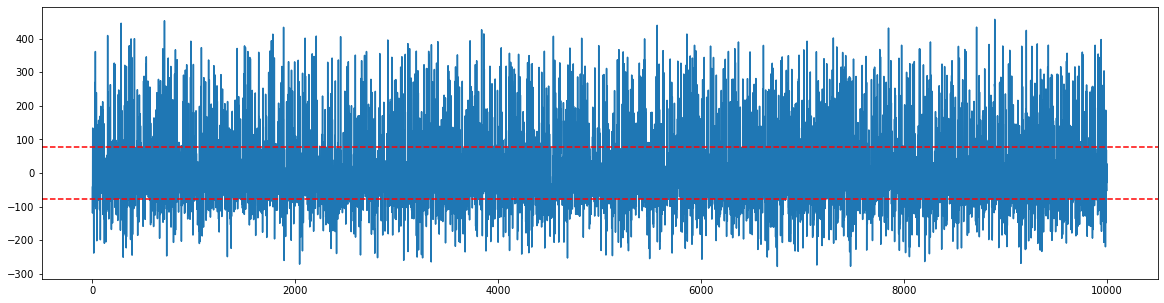

In [92]:
plt.figure(figsize=(20, 5))
plt.plot(range(10000), (y_test - y_pred_lr).sample(10000))
plt.axhline(mae_lr, c='r', linestyle='--')
plt.axhline(-mae_lr, c='r', linestyle='--')
plt.show()

Дерево решений

In [93]:
from sklearn.tree import DecisionTreeRegressor

In [95]:
dtr = DecisionTreeRegressor()

In [96]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [97]:
y_pred_dtr = dtr.predict(X_test)

Оцениваем среднюю абсолютную ошибку (MAE) и коэффициент детерминации (\$R^2$)

In [98]:
# MAE дерева решений
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)

In [99]:
mae_dtr

24.48353859666761

In [100]:
# R2
r2_dtr = r2_score(y_test, y_pred_dtr)

In [101]:
r2_dtr

0.7501679109703974

Отразим среднюю абсолютную ошибку дерева решений в виде графика

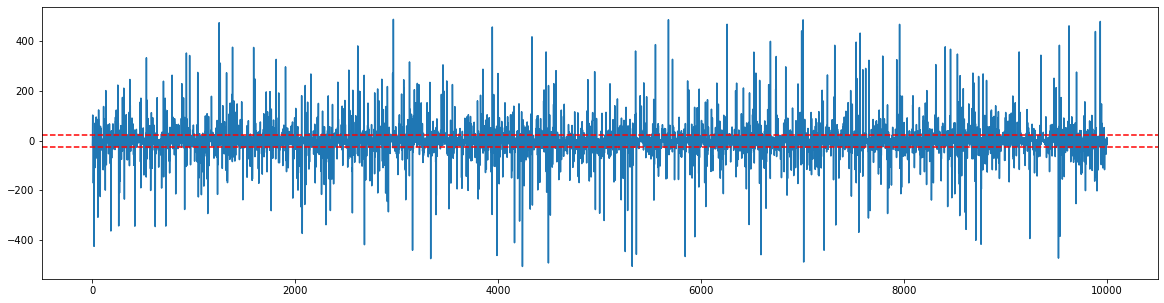

In [102]:
plt.figure(figsize=(20, 5))
plt.plot(range(10000), (y_test - y_pred_dtr).sample(10000))
plt.axhline(mae_dtr, c='r', linestyle='--')
plt.axhline(-mae_dtr, c='r', linestyle='--')
plt.show()

Для линейной регрессии фатальны выбросы, а для дерева решений главная проблема в том, что оно постоянно пытается переобучиться. И то, и другое влияние снижено в алгоритме Случайного леса, который выдаёт среднее по ответам деревьев в этом лесу.

Случайный лес

In [103]:
from sklearn.ensemble import RandomForestRegressor

In [104]:
rfr = RandomForestRegressor()

Поскольку алгоритм по умолчанию "медленный", то ограничу выборку по размеру

In [106]:
sampled = train.sample(100000)

In [107]:
X_sampled = scale_dataset(sampled)
y_sampled = sampled.value

Обучаем

In [124]:
rfr.fit(X_sampled, y_sampled)

RandomForestRegressor()

In [125]:
y_pred_rfr = rfr.predict(X_test)

Оцениваем среднюю абсолютную ошибку (MAE) и коэффициент детерминации (\$R^2$)

In [126]:
# MAE леса
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)

In [127]:
mae_rfr

35.42619655410818

In [128]:
# R2
r2_rfr = r2_score(y_test, y_pred_rfr)

In [129]:
r2_rfr

0.7139035399749958

Отразим среднюю абсолютную ошибку в виде графика

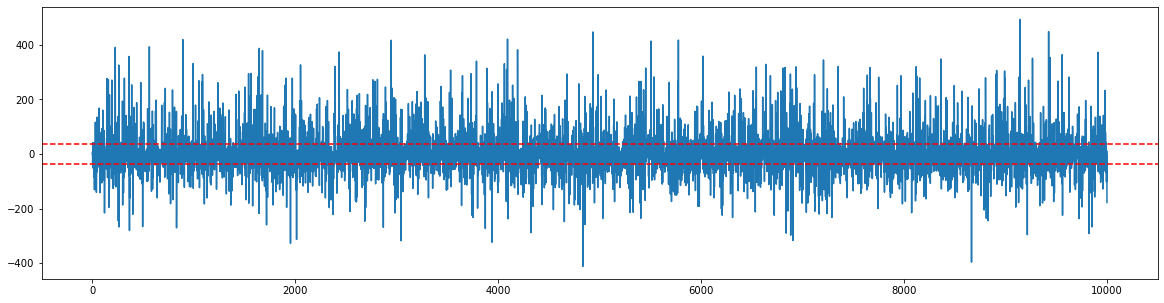

In [130]:
plt.figure(figsize=(20, 5))
plt.plot(range(10000), (y_test - y_pred_rfr).sample(10000))
plt.axhline(mae_rfr, c='r', linestyle='--')
plt.axhline(-mae_rfr, c='r', linestyle='--')
plt.show()

Поскольку для проверки алгоритма Случайного леса я использовал лишь часть тех данных, которые были даны на вход дереву решений (для экономии времени), то понижение метрик выглядит оправдано.

Попробуем ещё один алгоритм - Градиентный Бустинг от Microsoft, в котором каждое последующее дерево пытается учиться на ошибках предыдущего. Более того, алгоритм обычно быстрый

In [116]:
from lightgbm import LGBMRegressor

In [117]:
lgbm = LGBMRegressor()

In [118]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [119]:
y_pred_lgbm = lgbm.predict(X_test)

Оцениваем среднюю абсолютную ошибку (MAE) и коэффициент детерминации (\$R^2$)

In [120]:
# MAE дерева решений
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

In [121]:
mae_lgbm

61.296387739731976

In [122]:
# R2
r2_lgbm = r2_score(y_test, y_pred_lgbm)

In [123]:
r2_lgbm

0.4195010613330673

Отразим среднюю абсолютную ошибку в виде графика

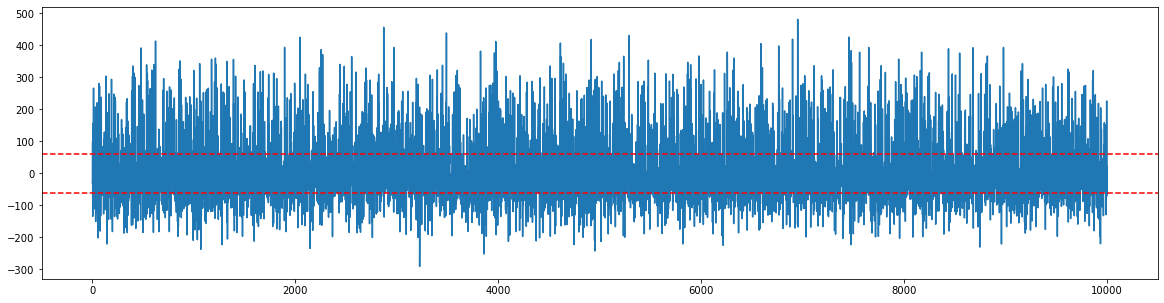

In [131]:
plt.figure(figsize=(20, 5))
plt.plot(range(10000), (y_test - y_pred_lgbm).sample(10000))
plt.axhline(mae_lgbm, c='r', linestyle='--')
plt.axhline(-mae_lgbm, c='r', linestyle='--')
plt.show()

Видимо, не в этот раз, Microsoft.

## 2. Выбор модели и настройка параметров

Поскольку в предыдущих модулях были обнаружены расхождения между train и test выборками, а также значительные выбросы, то остановимся на модели **Случайного леса**

### 2.1 Подбор гиперпараметров для дерева решений

Поскольку Случайный лес состоит из простых деревьев решений, а так же принимая во внимание, что процесс кросс-валидации и подбора параметров дорогостоящий и длительный, применим небольшую хитрость:
    
    1. подберем лучшие параметры для дерева решений
    2. подберем лучшую модель случайного леса на основе параметров из п.1

Главная проблема дерева решений - это стремление к переобучению. И это легко отобразить:

In [132]:
from sklearn.tree import plot_tree

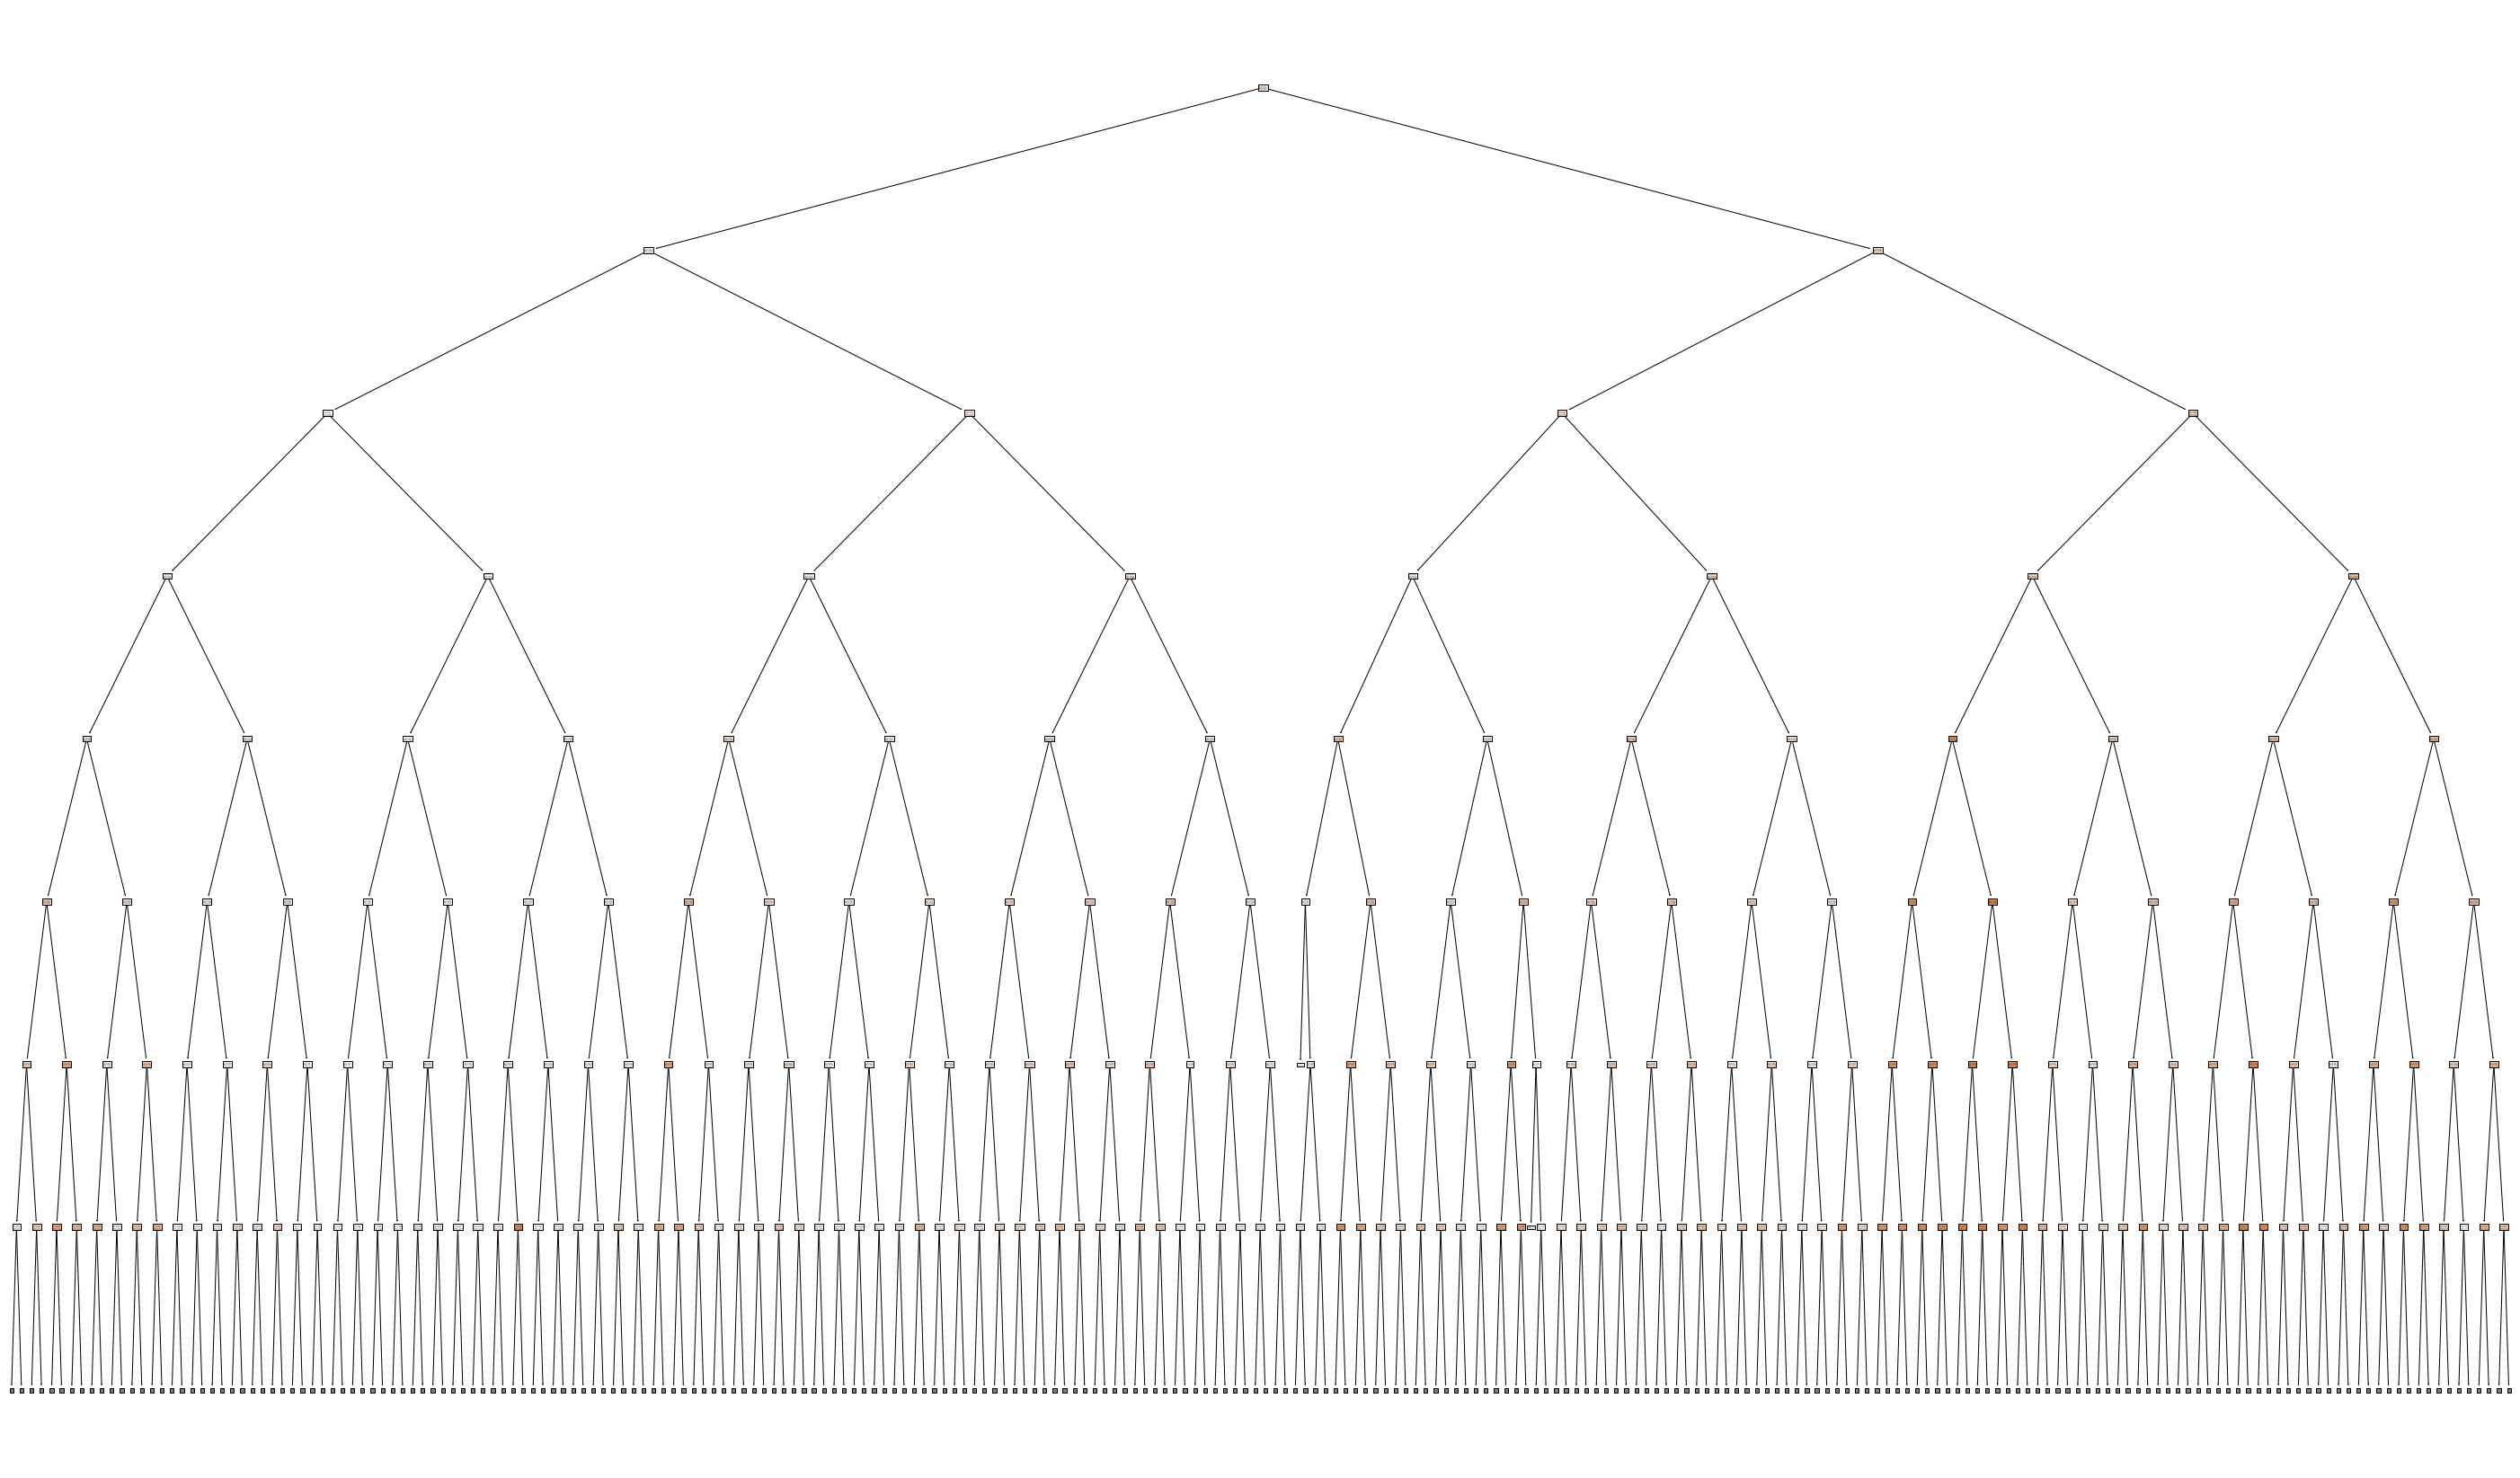

In [140]:
plt.figure(figsize=(50,30))
plot_tree(dtr, max_depth=7, filled=True)
plt.show()

Для того, чтобы избежать переобучение DecisionTree, сильно ограничим его глубину, а также количество сэмплов на лист (будем считать, что 1-2 cэмпла на лист это не более, чем частность)

In [141]:
from sklearn.model_selection import GridSearchCV

In [142]:
params_dtr = {
    'max_depth': range(5, 21, 5),
    'min_samples_split': range(2, 7),
    'min_samples_leaf': range(3, 8)
}

In [205]:
gscv_dtr = GridSearchCV(DecisionTreeRegressor(), param_grid=params_dtr, cv=5, verbose=True, n_jobs=-1, scoring='neg_mean_absolute_error')

In [206]:
gscv_dtr.fit(X_sampled, y_sampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(5, 21, 5),
                         'min_samples_leaf': range(3, 8),
                         'min_samples_split': range(2, 7)},
             scoring='neg_mean_absolute_error', verbose=True)

Лучшие параметры для DecisionTreeRegressor, выявленные в ходе работы GridSearchCV

In [207]:
gscv_dtr.best_params_

{'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 5}

Обучим дерево решений с выявленными лучшими параметрами

In [196]:
dtr2 = DecisionTreeRegressor(**gscv_dtr.best_params_)

In [197]:
dtr2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=7, min_samples_split=5)

In [198]:
mean_absolute_error(y_test, dtr2.predict(X_test))

31.45005047459122

In [199]:
r2_score(y_test, dtr2.predict(X_test))

0.7530366780485636

### 2.2 Подбор гиперпараметров для RandomForestRegressor

С лучшими параметрами для DecisionTree проведём подбор гиперпараметров для RandomForestRegressor

In [167]:
params_rfr = {
    'n_estimators': range(50, 201, 25),
    'max_depth': [20],
    'min_samples_split': [7],
    'min_samples_leaf': [5]
}

In [208]:
gscv_rfr = GridSearchCV(RandomForestRegressor(), param_grid=params_rfr, cv=2, verbose=True, n_jobs=-1, scoring='neg_mean_absolute_error')

In [209]:
gscv_rfr.fit(X_sampled, y_sampled)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20], 'min_samples_leaf': [5],
                         'min_samples_split': [7],
                         'n_estimators': range(50, 201, 25)},
             scoring='neg_mean_absolute_error', verbose=True)

Лучшие параметры для RandomForestRegressor, выявленные в ходе работы GridSearchCV

In [210]:
gscv_rfr.best_params_

{'max_depth': 20,
 'min_samples_leaf': 5,
 'min_samples_split': 7,
 'n_estimators': 175}

Обучим модель с лучшими параметрами

In [230]:
rfr2 = RandomForestRegressor(n_estimators=175, max_depth=20, min_samples_split=7, min_samples_leaf=5, n_jobs=-1)

In [231]:
rfr2.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=5, min_samples_split=7,
                      n_estimators=175, n_jobs=-1)

In [241]:
y_pred_rfr2 = rfr2.predict(X_test)

Метрики получившейся модели

In [242]:
mae_rfr2 = mean_absolute_error(y_test, y_pred_rfr2)

In [243]:
mae_rfr2

30.20382225856016

In [234]:
# R2
r2_score(y_test, rfr2.predict(X_test))

0.781567209457767

Отразим среднюю абсолютную ошибку в виде графика

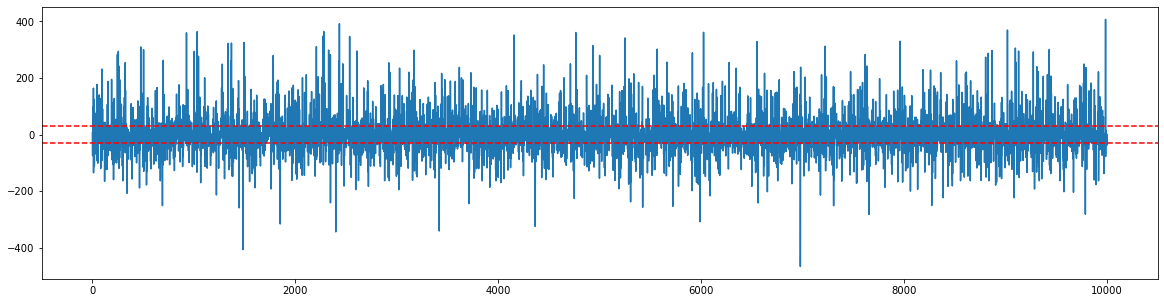

In [244]:
plt.figure(figsize=(20, 5))
plt.plot(range(10000), (y_test - y_pred_rfr2).sample(10000))
plt.axhline(mae_rfr2, c='r', linestyle='--')
plt.axhline(-mae_rfr2, c='r', linestyle='--')
plt.show()

### 2.3 Результат подбора параметров

Для **дерева решений**:

Средняя абсолютная ошибка увеличилась с 24.48 до 31.45 (**ухудшение**)

Коэффициент детерминации с 0.75 вырос до 0.753 (**незначительное улучшение**)

Для **cлучайного леса**:

Средняя абсолютная ошибка уменьшилась с 35.42 до 30.2 (**улучшение**)

Коэффициент детерминации с 0.7139 вырос до 0.7815 (**улучшение**)

В результате по имеющимся метрикам себя лучше проявила всё же модель **RandomForestRegressor**

Сохраним лучшую модель для того, чтобы в пайплайне её готовую загружать и выдавать результат быстрее без повторного обучения в "продакшне"

In [235]:
try:
    with open('best.model', 'wb') as f:
        pickle.dump(rfr2, f)
except Exception as e:
    print(f'Возникла ошибка сохранения модели: код {e.args[0]} "{e.args[1]}"')

# 3. Прогнозирование и продуктивизация

Обновлённая функция пайплайна

In [245]:
def pipeline():
    # грузим датасеты
    train_orig, building_meta_orig, weather_train_orig, weather_test_orig, test_orig = load_datasets()
    
    # подготавливаем train/test
    train_orig = prepare_train_test(train_orig)
    test_orig = prepare_train_test(test_orig)
    
    # подготавливаем датасет building_meta
    building_meta_orig = prepare_building_meta(building_meta_orig)
    
    # подготавливаем погодные датасеты
    weather_train_orig = prepare_weather(weather_train_orig)
    weather_test_orig = prepare_weather(weather_test_orig)
    
    # объединяем датасеты
    train = join_datasets(train_orig, building_meta_orig, weather_train_orig)
    test = join_datasets(test_orig, building_meta_orig, weather_test_orig)
    
    # удаляем "шум" в train-датасете
    train = remove_noise(train)
    
    # добавляем новые необходимые фичи
    train = feature_engineering(train)
    test = feature_engineering(test)
    
    # выносим obj_id в индекс
    train = train.set_index(train.obj_id).drop('obj_id', axis=1)
    test = test.set_index(test.obj_id).drop('obj_id', axis=1)
    
    # удалить лишние признаки
    train = train[['day_of_month', 'square', 'temp', 'function_2', 'pressure', 'counter_0', 'counter_1', 'counter_2', 'counter_3', 'value']]
    test = test[['day_of_month', 'square', 'temp', 'function_2', 'pressure', 'counter_0', 'counter_1', 'counter_2', 'counter_3']]
    
    # словарь подмен пропусков в датасете
    fillna_dict = {
        'temp': 15.0,
        'pressure': 1016.4,
        'square': 57673.0
    }
    
    # заполняем Nan, если вдруг такие возникли
    for col in fillna_dict.keys():
        train[col].fillna(fillna_dict[col], inplace=True)
        test[col].fillna(fillna_dict[col], inplace=True)
        
    # разбиваем train на X и y (объект-ответ) и масштабируем признаки
    X = scale_dataset(train)
    y = train.value
    # масштабируем признаки в test
    test = scale_dataset(test)
    
    # Разделяем train на тренировочную и валидационную (зачем это здесь? Но задание есть задание)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # загружаем готовую модель
    try:
        with open('best.model', 'rb') as f:
            model = pickle.load(f)
    except Exception as e:
        print(f'Возникла ошибка загрузки масштабиста: код {e.args[0]} "{e.args[1]}"')
    
    
    # предсказываем значения
    predict = pd.DataFrame(model.predict(test))
    
    # сохраняем предсказания
    try:
        predict.to_csv('predict.csv', index=False, header=False)
        print('Предсказания сохранены в файл "predict.csv"')
    except Exception as e:
        print(f'Возникла ошибка сохранения предсказаний: код {e.args[0]} "{e.args[1]}"')

Запускаем пайплайн для формирования предсказаний

In [246]:
pipeline()

Предсказания сохранены в файл "predict.csv"
